In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from math import sqrt
import skimage.morphology as skimo

In [93]:
def openImg(path="./Dataset/41033.jpg"):
    iimm = np.array(cv2.imread(path))
    iimm = cv2.cvtColor(iimm, cv2.COLOR_BGR2RGB)
    iimm = cv2.cvtColor(iimm, cv2.COLOR_RGB2LAB)
    return iimm.astype(np.float32)


def plot_img(im):
    im = im.astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    plt.imshow(im)
    plt.show()

def grad(img, x, y):
    if (x < 1 or x >= img.shape[0]-1 or y < 1 or y >= img.shape[1]-1):
        return 9223372036854775807
    A = pow(img[x+1][y][0] - img[x-1][y][0], 2) + pow(img[x+1][y][1] - img[x-1][y][1], 2) + pow(img[x+1][y][2] - img[x-1][y][2], 2)
    B = pow(img[x][y+1][0] - img[x][y-1][0], 2) + pow(img[x][y+1][1] - img[x][y-1][1], 2) + pow(img[x][y+1][2] - img[x][y-1][2], 2)
    return int((A + B) * 1000)

'''
def grad(image, i, j):
    i = min(i, image.shape[0] - 2)
    j = min(j, image.shape[1] - 2)
    return sqrt((image[i + 1, j] - image[i - 1, j]) ** 2 + (image[i, j + 1] - image[i, j - 1]) ** 2)
'''

def mingrad(img, x, y):
    d = {}
    d[grad(img, x-1, y-1)] = (x-1, y-1)
    d[grad(img, x,   y-1)] = (x,   y-1)
    d[grad(img, x+1, y-1)] = (x+1, y-1)
    d[grad(img, x-1, y)]   = (x-1, y)
    d[grad(img, x,   y)]   = (x  , y)
    d[grad(img, x+1, y)]   = (x+1, y)
    d[grad(img, x-1, y+1)] = (x-1, y+1)
    d[grad(img, x,   y+1)] = (x  , y+1)
    d[grad(img, x+1, y+1)] = (x+1, y+1)
    return d[min(d.keys())]   
    
def make_color_points(im, k):
    length = im.shape[0] * im.shape[1]
    s = int(np.sqrt(length / k))
    h = s//2
    w = s//2
    centers = []
    cpt = 0
    while w < im.shape[1]:
        cpt+=1
        w+=s
    w=s//2
    
    while h < im.shape[0]:
        while w < im.shape[1]:
            centers.append((h, w))
            w += s
        w = s//2
        h += s
    
    return centers, cpt
    


def plot_points_to_img(im, color_points):
    plt.imshow(compute_gradient(im).astype(np.uint8))
    for elm in color_points:
        plt.scatter(elm[0], elm[1], marker='o')
    plt.show()


def lab_dist(arr1, arr2):
    return sqrt(pow(arr1[0] - arr2[0], 2) + pow(arr1[1] - arr2[1], 2) + pow(arr1[2] - arr2[2], 2))

def xy_dist(arr1, arr2):
    return sqrt(pow(arr1[0] - arr2[0], 2) + pow(arr1[1] - arr2[1], 2))


def distance_color(coordpoint, colorpoint, coordcenter, colorcenter, s):
    m = 30
    dlab = lab_dist(colorcenter, colorpoint)
    dxy = xy_dist(coordcenter, coordpoint)
    cooef = m / s
    return dlab + cooef * dxy

def moy_tuple(l):
    x = 0
    y = 0
    for e in l:
        x += e[1]
        y += e[0]
    x = x//len(l)
    y = y//len(l)
    return (y, x)

def make_image(im, color_points, k):
    img_height = im.shape[0]
    img_width = im.shape[1]
    length = img_width * img_height
    S = int(np.sqrt(length / k))
    SS = 2*S
    res = np.zeros(im.shape)
    
    d = {}
    for i in range(len(color_points)):
        d[i] = []

    count = 1
    #change = True
    while count > 0:
        #change = False
        count -= 1
        
        for i in range(img_height): #add point to cluster
            for j in range(img_width):
                c_i = 0
                c_x = 0
                c_y = 0
                d_min = 9223372036854775807
                for k, c in enumerate(color_points):
                    if c[0] > i-SS and c[0] < i+SS and c[1] > j-SS and c[1] < j+SS:
                        dist = distance_color((i, j), im[i][j], c, im[c[0]][c[1]], S)
                        if dist < d_min:
                            d_min = dist
                            c_y = c[0]
                            c_x = c[1]
                            c_i = k

                if (c_x == 0 and c_y == 0) or (i, j) in d[c_i]:
                    continue
                    
                if np.not_equal(res[i][j], [0, 0, 0]).any():
                    for k in range(len(color_points)):
                        if (i, j) in d[k]:
                            d[k].remove((i, j))
                            break;
                res[i][j] = im[c_y][c_x]
                d[c_i].append((i, j))
                #change = True

        for k in range(len(color_points)): #move center
            color_points[k] = moy_tuple(d[k])
            
    for i in range(img_height): #connectivity
        for j in range(img_width):
            if np.equal(res[i][j], [0, 0, 0]).all():
                c_i = 0
                c_x = 0
                c_y = 0
                d_min = 9223372036854775807
                for k, c in enumerate([(i-1, j), (i, j-1), (i+1, j), (i,j+1)]):
                    dist = distance_color((i, j), im[i][j], c, im[c[0]][c[1]], S)
                    if dist < d_min:
                        d_min = dist
                        c_y = c[0]
                        c_x = c[1]
                        c_i = k
                res[i][j] = im[c_y][c_x]
                d[c_i].append((i, j))
            
    return (res, d)

def add_points_to_img(im, color_points):
    im = im.astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    plt.imshow(im)
    for elm in color_points:
        plt.scatter(elm[1], elm[0], marker='o')
    plt.show()

In [3]:
def make_pow2_circle():
    tmp = np.full((3, 3), 0)
    tmp[1, 2] = 2 ** 0
    tmp[2, 2] = 2 ** 1
    tmp[2, 1] = 2 ** 2
    tmp[2, 0] = 2 ** 3
    tmp[1, 0] = 2 ** 4
    tmp[0, 0] = 2 ** 5
    tmp[0, 1] = 2 ** 6
    tmp[0, 2] = 2 ** 7
    return tmp


### This has to be applied on the whole image
def compute_elm_of_area_3x3(roi, pow2_circ):
    tmp = np.zeros(roi.shape)
    val = roi[1, 1]
    tmp[roi >= val] = 1
    tmp[1, 1] = 0
    res = pow2_circ * tmp
    return np.add.reduce(res, (0, 1))


def apply_lbp_on_image(img):
    tmp = np.zeros(img.shape)
    pow2_circ = make_pow2_circle()

    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            tmp[i, j] = compute_elm_of_area_3x3(img[i - 1:i + 2, j - 1:j + 2], pow2_circ)

    return tmp


def openImgLBP(path):
    iimm = np.array(cv2.imread(path))
    iimm = cv2.cvtColor(iimm, cv2.COLOR_BGR2RGB)
    iimm = cv2.cvtColor(iimm, cv2.COLOR_RGB2GRAY)
    return iimm.astype(np.float32)


def plot_img_lbp(im):
    fig, ax = plt.subplots(figsize=(19, 11))
    im = im.astype(np.uint8)
    ax.imshow(im, aspect='auto', interpolation='nearest', cmap='gray')
    plt.show()


def comparison_func(img):
    return feature.local_binary_pattern(img, 8, 1, method="default")

def fromlabtolbp(img):
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.float32)
    return img

In [4]:
def compute_elm_of_area_3x3_from_slic(img, i, j, c, pow2_circ):
    tmp = np.zeros((3, 3))
    val = img[i, j]
    
    tmp[0][0] = 1 if ((i-1, j-1) in c and img[i-1][j-1] >= val) else 0
    tmp[0][1] = 1 if ((i-1, j)   in c and img[i-1][j]   >= val) else 0
    tmp[0][2] = 1 if ((i-1, j+1) in c and img[i-1][j+1] >= val) else 0
    tmp[1][0] = 1 if ((i, j-1)   in c and img[i][j-1]   >= val) else 0
    tmp[1][1] = 0
    tmp[1][2] = 1 if ((i, j+1)   in c and img[i][j+1]   >= val) else 0
    tmp[2][0] = 1 if ((i+1, j-1) in c and img[i+1][j-1] >= val) else 0
    tmp[2][1] = 1 if ((i+1, j)   in c and img[i+1][j]   >= val) else 0
    tmp[2][2] = 1 if ((i+1, j+1) in c and img[i+1][j+1] >= val) else 0
    
    res = pow2_circ * tmp
    return np.add.reduce(res, (0, 1))

def lbponslic(img, clusters):
    tmp = np.zeros(img.shape)
    pow2_circ = make_pow2_circle()
    
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            c = clusters[0]
            for e in range(len(clusters)):
                if (i, j) in clusters[e]:
                    c = clusters[e]
                    break
            tmp[i, j] = compute_elm_of_area_3x3_from_slic(img, i, j, c, pow2_circ)

    return tmp

In [5]:
def addborder(img, slic_im):
    res = img.copy()
    for i in range(1, img.shape[0]-2):
        for j in range(1, img.shape[1]-2):
            for k in ((i, j-1), (i, j+1), (i-1, j), (i+1, j)):
                if np.any(slic_im[i][j] != slic_im[k[0]][k[1]]):
                    res[i][j] = [0, 0, 0]
                    break
    
    return res

In [33]:
def valuesupepix(cluster, lbp, slic):
    lbpval = 0
    slicval = 0
    
    for e in cluster:
        lbpval += lbp[e]
    if len(cluster) != 0:
        lbpval = lbpval//len(cluster)
        
    rgb = slic.astype(np.uint8)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_LAB2RGB)
    slicvals = rgb[cluster[0][0]][cluster[0][1]]
    slicval = round(0.3 * slicvals[0] + 0.59 * slicvals[1] + 0.11 * slicvals[2])
    
    return lbpval + slicval * 0.3

def fuse_cluster(centers, clusters, lbp, slic, nb_length, dist):
    to_fuse = []
    nb_center = len(centers)
    h = int(np.sqrt(lbp.shape[0] * lbp.shape[1] / nb_center))//2
    mean = {}
    
    for i in range(nb_center):
        mean[i] = valuesupepix(clusters[i], lbp, slic)
        
    for i in range(nb_center):
        if i+1 < nb_center and abs(mean[i] - mean[i+1]) < dist and (i, i+1) not in to_fuse and (i+1, i) not in to_fuse:
            to_fuse.append((i, i+1))
        if i-1 > -1 and abs(mean[i] - mean[i-1]) < dist and (i, i-1) not in to_fuse and (i-1, i) not in to_fuse:
            to_fuse.append((i, i-1))
        if i+nb_length < nb_center and abs(mean[i] - mean[i+nb_length]) < dist and (i, i+nb_length) not in to_fuse and (i+nb_length, i) not in to_fuse:
            to_fuse.append((i, i+nb_length))
        if i-nb_length > -1 and abs(mean[i] - mean[i-nb_length]) < dist and (i, i-nb_length) not in to_fuse and (i-nb_length, i) not in to_fuse:
            to_fuse.append((i, i+nb_length))

    return to_fuse

In [7]:
def fuse(to_fuse, centers, clusters):
    res = clusters.copy()

    for (i, j) in to_fuse:
        for e in clusters[i]:
            res[j].append(e)
        res[i] = []
        res[j].append(centers[i])
    
    return res

In [8]:
def fromimtoslic(im, centers, clusters):
    res = np.zeros(im.shape)
    
    for i, c in enumerate(centers):
        if len(clusters[i]) > 0:
            res[c[0]][c[1]] = im[c[0]][c[1]]
    
    for i, c in enumerate(centers):
        for e in clusters[i]:
            res[e[0]][e[1]] = im[c[0]][c[1]]
    
    return res

In [35]:
def calculpix(im, nb_points, dist=0, print_fuse=False):
    color_points, nb_length = make_color_points(im, nb_point)
    slic_im, d = make_image(im, color_points, nb_point)
    
    imlbp = fromlabtolbp(im)
    lbp = apply_lbp_on_image(imlbp)
    
    to_fuse = fuse_cluster(color_points, d, lbp.astype(np.uint8), slic_im, nb_length, dist)
    dfuse = fuse(to_fuse, color_points, d)
    
    res = fromimtoslic(im, color_points, dfuse)
    
    if print_fuse:
        fuseborder = addborder(im, res)
        plot_img(fuseborder)
    
    return res

In [79]:
def plop(path, nb_point, dist):
    im = openImg(path)
    plot_img(im)
    
    res = calculpix(im, nb_point, dist)
    plot_img(res)
    
    morpho = cv2.cvtColor(res.astype(np.uint8), cv2.COLOR_LAB2RGB)
    morpho = cv2.cvtColor(morpho, cv2.COLOR_RGB2GRAY)
    morpho = skimo.area_opening(skimo.area_closing(morpho))
    plt.imshow(morpho, cmap='gray')
    plt.show()
    
    fuseborder = addborder(im, morpho)
    plot_img(fuseborder)

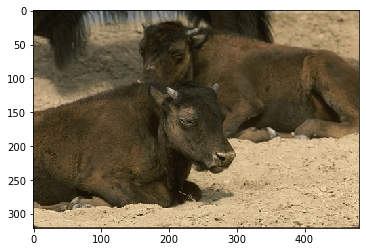

Done.


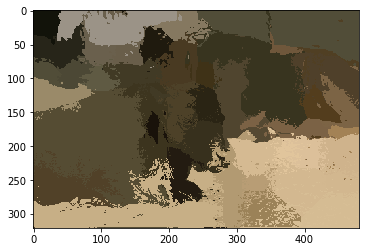

Done.


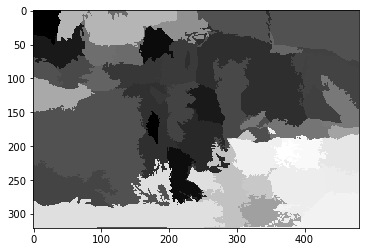

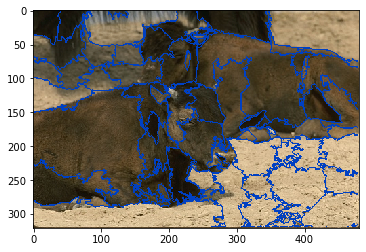

Done.


In [81]:
plop("./Dataset/41033.jpg", 100, 15)

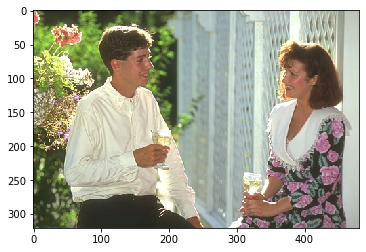

Done.


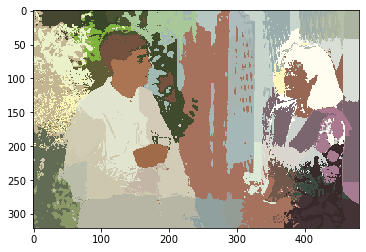

Done.


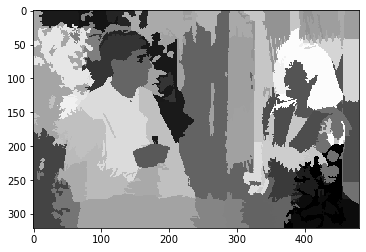

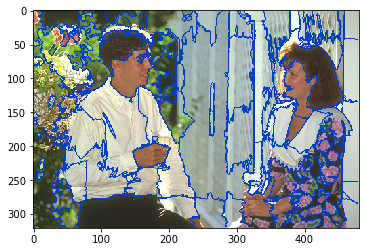

Done.


In [89]:
plop("./Dataset/157055.jpg", 100, 13)

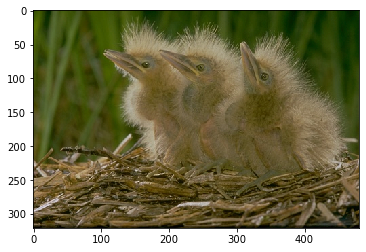

Done.


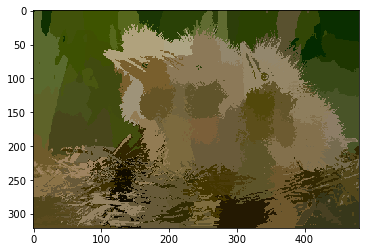

Done.


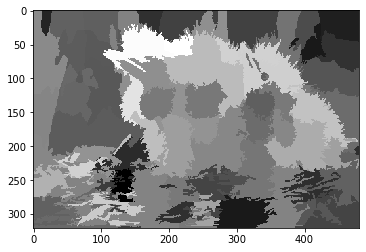

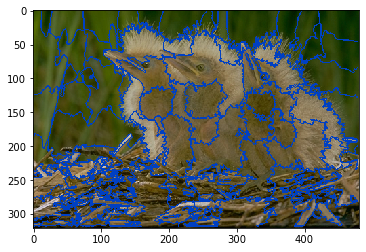

Done.


In [84]:
plop("./Dataset/163085.jpg", 100, 12)